In [140]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("umitka/synthetic-financial-fraud-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\davee\.cache\kagglehub\datasets\umitka\synthetic-financial-fraud-dataset\versions\1


In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
# Load dataset
df = pd.read_csv("synthetic_fraud_dataset.csv")

# Drop identifier columns
df = df.drop(["transaction_id", "user_id"], axis=1)



In [143]:
import numpy as np

# --- 1. Combined risk score ---
df["risk_total"] = df["device_risk_score"] + df["ip_risk_score"]

# --- 2. Night-time transaction (fraud often spikes at night) ---
df["is_night"] = df["hour"].apply(lambda h: 1 if h < 6 or h > 22 else 0)

# --- 3. Log-transformed amount (reduces influence of extreme values) ---
df["log_amount"] = np.log1p(df["amount"])

# --- 4. Merchant category fraud rate encoding ---
merchant_risk = df.groupby("merchant_category")["is_fraud"].mean()
df["merchant_risk"] = df["merchant_category"].map(merchant_risk)

# --- 5. Country fraud rate encoding ---
country_risk = df.groupby("country")["is_fraud"].mean()
df["country_risk"] = df["country"].map(country_risk)

# --- 6. Amount × risk interaction feature ---
df["amount_risk_interaction"] = df["amount"] * df["risk_total"]

df.head()


,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud,risk_total,is_night,log_amount,merchant_risk,country_risk,amount_risk_interaction
0,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,1,1.940254,0,8.501793,0.052605,0.038900,9551.071155
1,48.018303,QR,Food,US,21,0.168571,0.224057,0,0.392629,0,3.892194,0.045477,0.047317,18.853361
2,136.881960,Online,Travel,TR,14,0.296127,0.125058,0,0.421185,0,4.926398,0.052605,0.038900,57.652620
3,80.534719,POS,Clothing,TR,23,0.124801,0.159243,0,0.284043,1,4.401029,0.054995,0.038900,22.875362
4,120.041158,Online,Grocery,FR,16,0.098129,0.027542,0,0.125671,0,4.796131,0.048150,0.036507,15.085683


In [144]:

X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

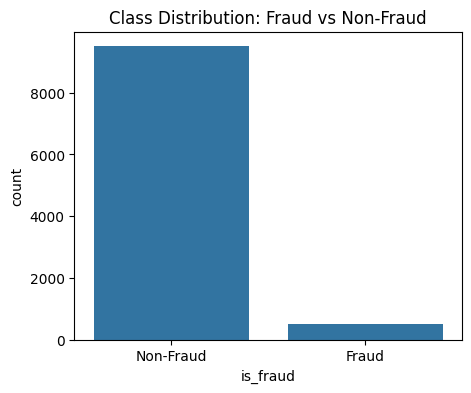

is_fraud
0    9500
1     500
Name: count, dtype: int64


In [145]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="is_fraud")
plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.show()

print(df["is_fraud"].value_counts())

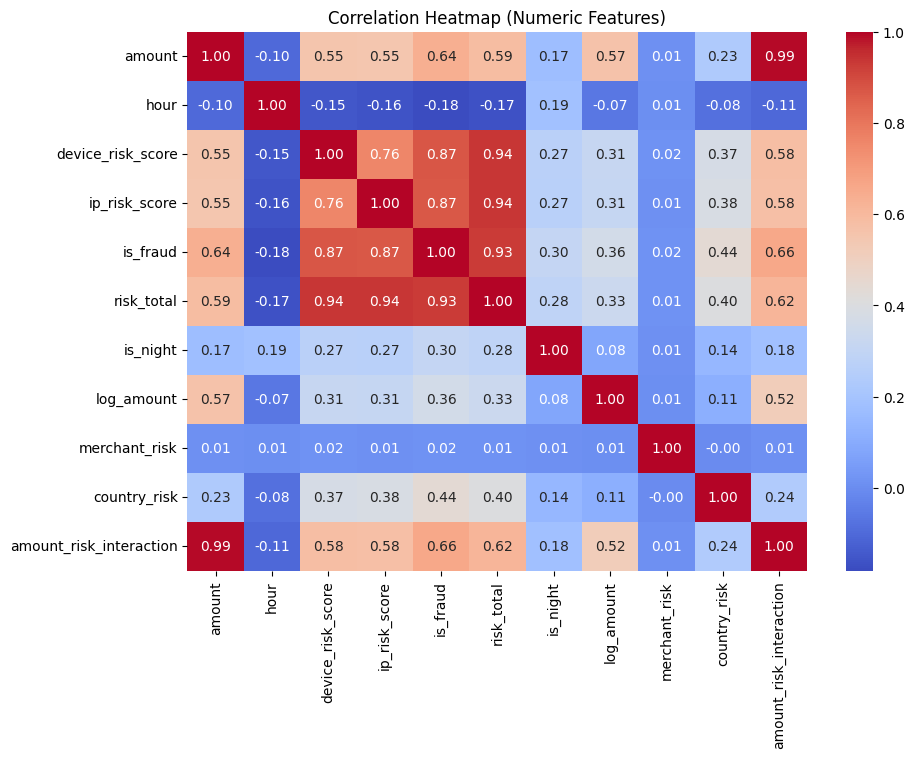

In [146]:
plt.figure(figsize=(10,7))
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


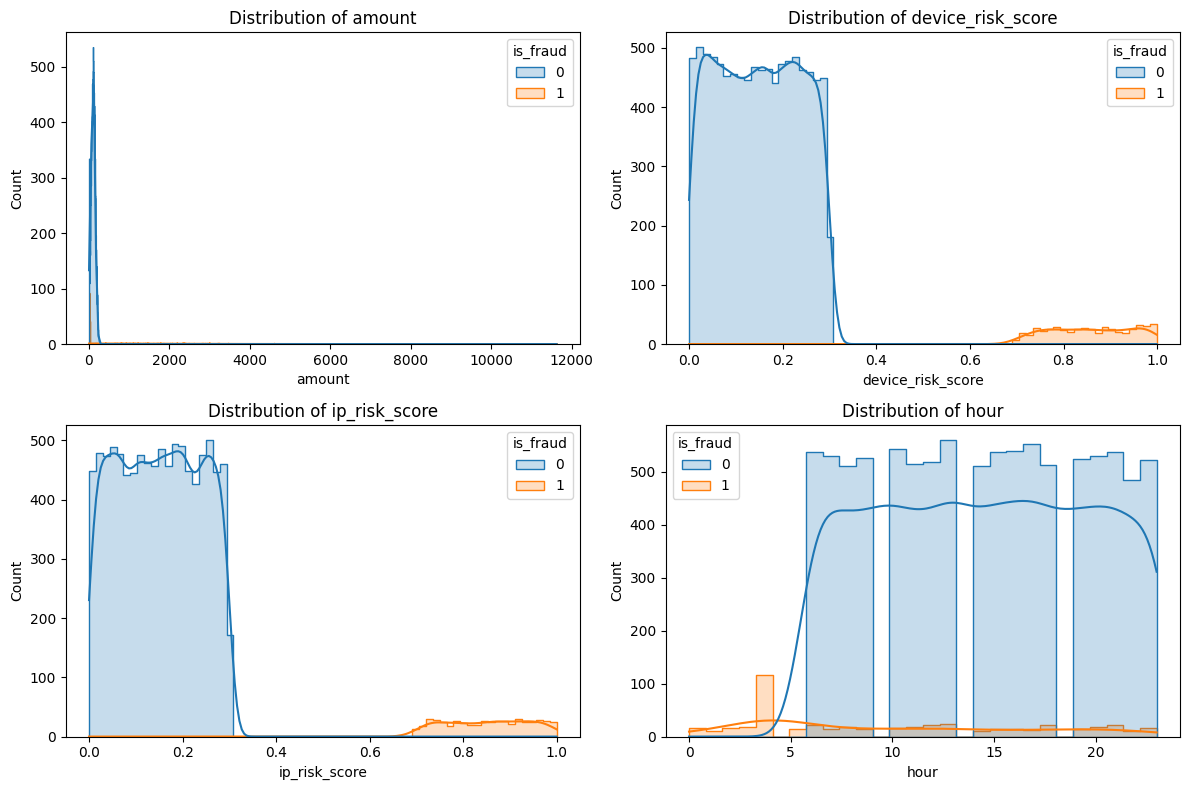

In [147]:
num_features = ["amount", "device_risk_score", "ip_risk_score", "hour"]

plt.figure(figsize=(12,8))
for i, col in enumerate(num_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col, hue="is_fraud", kde=True, element="step")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


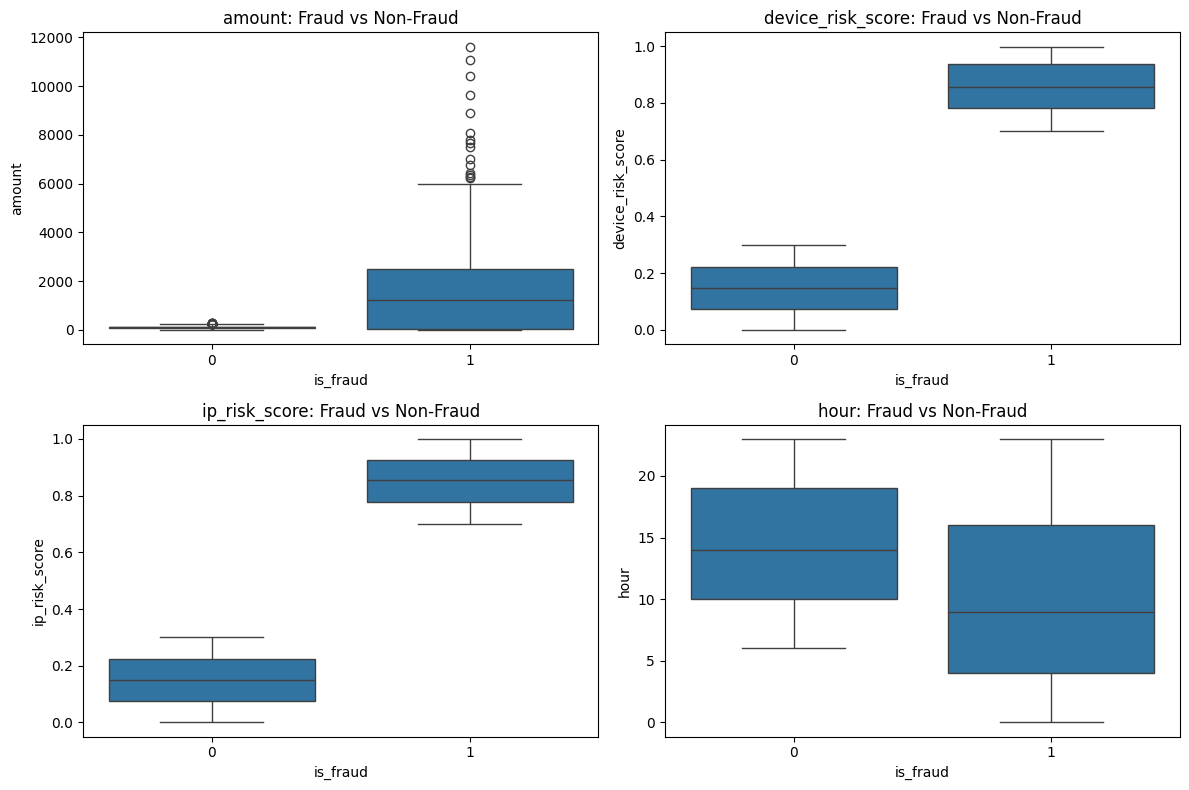

In [148]:
plt.figure(figsize=(12,8))
for i, col in enumerate(num_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=df, x="is_fraud", y=col)
    plt.title(f"{col}: Fraud vs Non-Fraud")
plt.tight_layout()
plt.show()


In [149]:
categorical_cols = ["transaction_type", "merchant_category", "country"]

numeric_cols = [
    "amount",
    "hour",
    "device_risk_score",
    "ip_risk_score",
    "risk_total",
    "is_night",
    "log_amount",
    "merchant_risk",
    "country_risk",
    "amount_risk_interaction",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

In [150]:
# Model
model = RandomForestClassifier(class_weight="balanced", random_state=42)


# Pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [151]:
# Hyperparameter search space for RandomForest inside the pipeline
param_distributions = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"],
}


In [152]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

# Randomized search over hyperparameters
search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_distributions,
    n_iter=20,           # number of random combinations to try
    scoring="roc_auc",   # good metric for fraud
    cv=3,                # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,           # use all cores
    random_state=42,
)

print("Starting hyperparameter search...")
search.fit(X_train, y_train)

print("\nBest ROC–AUC score from CV:", search.best_score_)
print("Best hyperparameters:", search.best_params_)

# Use the best model found
best_clf = search.best_estimator_

# Predict with best model
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
y_test_proba = best_clf.predict_proba(X_test)[:, 1]

# Basic accuracy
print("\n=== Final model performance ===")
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

# More useful metrics
print("\n=== Test set metrics ===")
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score:", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC–AUC:", roc_auc_score(y_test, y_test_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion matrix:")
print(cm)

# Classification report
print("\nClassification report:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best ROC–AUC score from CV: 1.0
Best hyperparameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None}

=== Final model performance ===
Train accuracy: 1.0
Test accuracy: 1.0

=== Test set metrics ===
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC–AUC: 1.0

Confusion matrix:
[[1887    0]
 [   0  113]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1887
           1       1.00      1.00      1.00       113

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the preprocessing and model steps from the best pipeline
best_preprocess = best_clf.named_steps["preprocessor"]
best_model = best_clf.named_steps["model"]

# === 1. Get feature names FROM the fitted ColumnTransformer ===

# transformer structure: [("cat", ohe, cat_cols), ("num", "passthrough", num_cols)]
cat_transform_name, cat_transformer, cat_cols = best_preprocess.transformers_[0]
num_transform_name, num_transformer, num_cols = best_preprocess.transformers_[1]

# Safety print (you can comment this out later)
print("Categorical columns in preprocessor:", cat_cols)
print("Numeric columns in preprocessor:", num_cols)

# OneHotEncoder for categorical features
ohe = best_preprocess.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

# Numeric features pass through unchanged
num_feature_names = np.array(num_cols)

# Combine into a single feature name array
all_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# === 2. Get feature importances from the RandomForest ===
importances = best_model.feature_importances_

print("\nLen(all_feature_names):", len(all_feature_names))
print("Len(importances):", len(importances))

# === 3. Put into a DataFrame for easier sorting/plotting ===
fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Show top 20 features
fi_df.head(20)



Categorical columns in preprocessor: ['transaction_type', 'merchant_category', 'country']
Numeric columns in preprocessor: ['amount', 'hour', 'device_risk_score', 'ip_risk_score', 'risk_total', 'is_night', 'log_amount', 'merchant_risk', 'country_risk', 'amount_risk_interaction']

Len(all_feature_names): 25
Len(importances): 25


,feature,importance
18,ip_risk_score,0.251473
17,device_risk_score,0.239643
19,risk_total,0.235663
24,amount_risk_interaction,0.083459
21,log_amount,0.074833
15,amount,0.070140
16,hour,0.013996
20,is_night,0.013427
11,country_NG,0.009018
23,country_risk,0.007216


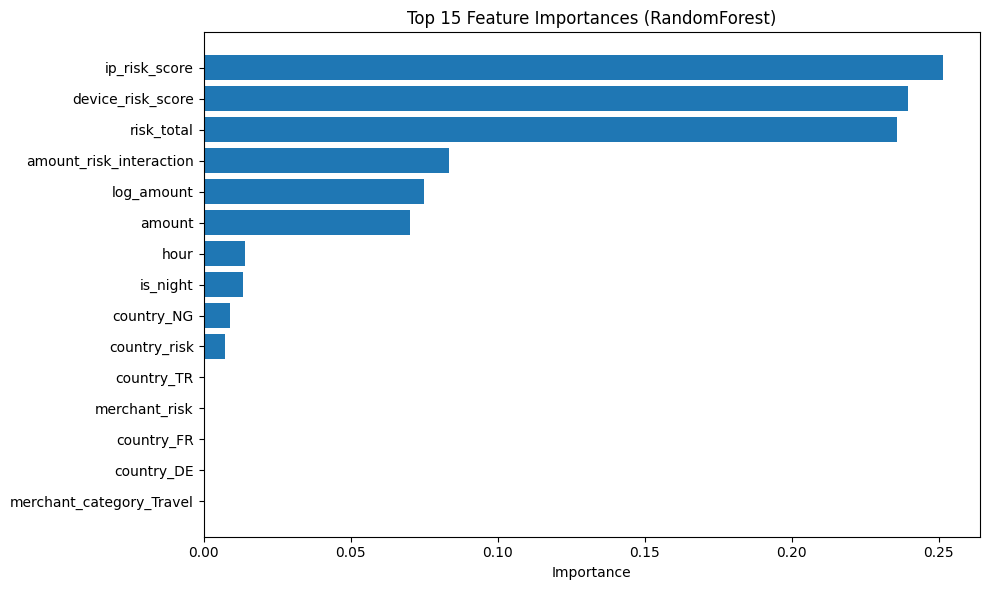

In [154]:
# Plot top 15 important features
top_n = 15
top_features = fi_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()
